# Reference Scenario Plots

## Setup

In [ ]:
AGGREGATION_PERIOD: float = 1.0
information = "../../data/reference-scenarios"
information_custom = "../../data/custom-references-0.005"
data_dir = information

In [2]:
plot_dir = "out"
fig_width = 12.0 # Width of a figure that spans 100% of the page width
fig_height = 8.0 # Height of a figure that spans 100% of the page width
def fig_size(scale=1.0, height=1.0):
    return (fig_width * scale, fig_height * scale * height)

In [3]:
import os
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import colorsys
import matplotlib.colors as mcolors

In [4]:
sns.set_theme(palette='colorblind', color_codes=True)

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)
plt.rcParams['figure.dpi'] = 72
#plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.monospace'] = 'cmtt10'
plt.rcParams["axes.formatter.use_mathtext"] = True # to fix the minus signs

In [5]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot_d(func, save_dir):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(save_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(save_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

plot = functools.partial(plot_d, save_dir=plot_dir)

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pickle
from tqdm import tqdm
import itertools
import functools

from typing import NamedTuple, Any
import os
import math
from enum import Enum

In [ ]:
from dsns.simulation import LoggingActor, Simulation
from dsns.message import (
    LTPConfig,
    LossConfig,
    DirectMessage,
    DropReason,
    MessageCreatedEvent,
    MessageDeliveredEvent,
    MessageDroppedEvent,
)
from dsns.multiconstellation import MultiConstellation
from dsns.presets import (
    IridiumMultiConstellation,
    StarlinkMultiConstellation,
    CubesatMultiConstellation,
    LeoLeoMultiConstellation,
    LeoMeoMultiConstellation,
    LeoGeoMultiConstellation,
    LeoMeoGeoMultiConstellation,
    EarthMoonMarsMultiConstellation,
)
from dsns.helpers import SatID
from dsns.logging import BandwidthLoggingActor, LTPTransmissionLoggingActor, PreprocessedLoggingActor
from dsns.transmission import LTPMessageRetransmissionActor, LinkTransmissionActor, RetransmissionConfig

In [8]:
def round_up_to_sig_fig(n):
   order_of_mag = math.floor(math.log10(abs(n)))
   return math.ceil(n / 10**order_of_mag) * 10**order_of_mag

In [9]:
def get_file_name(config: dict[str, Any], data_dir: str, which: str = "base") -> str:
    if which == "base":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}.pickle")
    elif which == "bw":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}-bw-{AGGREGATION_PERIOD}.pickle")
    elif which == "ltp":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}-ltp-{AGGREGATION_PERIOD}.pickle")

In [10]:
def make_configs_product(configs: dict[str, list[Any]], data_dir: str) -> list[dict[str, Any]]:
    cs = [ dict(zip(configs.keys(), values)) for values in itertools.product(*configs.values()) ]
    for config in cs:
        config["output_file"] = get_file_name(config, data_dir, "base")
        config["output_file_bw"] = get_file_name(config, data_dir, "bw")
        config["output_file_ltp"] = get_file_name(config, data_dir, "ltp")
    return cs

In [11]:
from pathlib import Path

def add_suffix_to_filename(path_str: str, suffix: str) -> str:
    path = Path(path_str)
    new_name = path.stem + suffix + path.suffix
    return str(path.with_name(new_name))

def load_config_all(config: dict[str, Any]):
    with open(config["output_file"], "rb") as f:
        direct_messages, broadcast_messages, other_events = pickle.load(f)
    return direct_messages, broadcast_messages, other_events

def load_config_bandwidth(config: dict[str, Any]):
    bw_output_file = config["output_file_bw"]
    with open(bw_output_file, "rb") as f:
        link_to_bandwidth_use_statistics = pickle.load(f)
    return link_to_bandwidth_use_statistics

def load_config_ltp(config: dict[str, Any]):
    ltp_output_file = config["output_file_ltp"]
    with open(ltp_output_file, "rb") as f:
        underying_message_to_transmission_statistics, segment_to_transmission_statistics, underying_message_to_loss_statistics, segment_to_loss_statistics = pickle.load(f)
    return underying_message_to_transmission_statistics, segment_to_transmission_statistics, underying_message_to_loss_statistics, segment_to_loss_statistics


## Load Data

### CCSDS

In [12]:
configs_setup: dict[str, list[Any]] = dict(
    scenario = ["eos", "lunar", "mars"],
    delivery = ["best_effort", "store_and_forward", "ltp"],
    loss = [0.05],
)

data_path = data_dir
configs = make_configs_product(configs_setup, data_path)
for i, config in enumerate(configs):
    for suffix in ["", "_bw", "_ltp"]:
        if not os.path.exists(config['output_file'+suffix]):
            print(f"{i+1}/{len(configs)}. ", os.path.exists(config['output_file'+suffix]), f"{config['output_file'+suffix]}")

In [13]:
path = f"{information}/bandwidth-reference-scenarios.pickle"
force_load = False

if os.path.exists(path) and not force_load:
    df_bw = pd.read_pickle(path)
else:
    records = []
    for config in tqdm(configs):
        scenario = config['scenario']
        delivery = config['delivery']
        loss = config.get('loss')
        try:
            stats = load_config_bandwidth(config)
        except FileNotFoundError as e:
            print(f"not found file for {config}")
            continue

        for link, interval_map in stats.items():
            source = getattr(link, "source", None)
            destination = getattr(link, "destination", None)
            link_label = (
                f"{source}->{destination}"
                if source is not None and destination is not None
                else repr(link)
            )

            for interval, (avg_q_len, total_sent, throughput, bw_use_ratio) in interval_map.items():
                start = interval.start_time
                end   = interval.end_time

                records.append({
                    "scenario":              scenario,
                    "delivery":              delivery,
                    "loss":                  loss,
                    "source":                source,
                    "destination":           destination,
                    "link":                  link_label,
                    "interval_start":        start,
                    "interval_end":          end,
                    "average_queue_size":    avg_q_len,
                    "total_data_sent":       total_sent,
                    "throughput":            throughput,
                    "bandwidth_use_ratio":   bw_use_ratio,
                })

    df_bw = pd.DataFrame.from_records(records)
    del records
    df_bw.to_pickle(path)


In [14]:
dfs = []
for config in tqdm(configs):
    try:
        direct_messages, broadcast_messages, other_events = load_config_all(config)
        del broadcast_messages, other_events
    except FileNotFoundError:
        print(f"missing file {config['output_file']}")
        continue

    try:
        temp_df = pd.DataFrame(direct_messages.values())

        temp_df['scenario'] = config['scenario']
        temp_df['delivery'] = config['delivery']
        temp_df['loss'] = config['loss']
        dfs.append(temp_df)

    except:
        print(config)
        raise

df_messages = pd.concat(dfs, ignore_index=True)
df_messages


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:32<00:00,  3.61s/it]


,message,source,destination,start_time,end_time,hops,delivered,dropped,drop_reason,aborted,scenario,delivery,loss
0,"DirectMessage(source=0, data='TC-0', time=0, h...",0,4,0.0,0.000041,NaN,False,True,DropReason.INSUFFICIENT_BUFFER,False,eos,best_effort,0.05
1,"DirectMessage(source=4, data='Payload-0', time...",4,1,0.0,0.000000,NaN,False,True,DropReason.INSUFFICIENT_BUFFER,False,eos,best_effort,0.05
2,"DirectMessage(source=4, data='TM-0', time=0, h...",4,0,0.0,0.000000,NaN,False,True,DropReason.INSUFFICIENT_BUFFER,False,eos,best_effort,0.05
3,"DirectMessage(source=4, data='Payload-1', time...",4,1,11.5,11.500000,NaN,False,True,DropReason.INSUFFICIENT_BUFFER,False,eos,best_effort,0.05
4,"DirectMessage(source=4, data='Payload-2', time...",4,1,23.0,23.000000,NaN,False,True,DropReason.INSUFFICIENT_BUFFER,False,eos,best_effort,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380745,"HybridDirectMessage(source=8, data='Payload-Ro...",8,1,86397.0,88050.534559,5.0,True,True,DropReason.DUPLICATE,False,mars,ltp,0.05
1380746,"HybridDirectMessage(source=7, data='Payload-Ro...",7,0,86398.0,87657.384046,5.0,True,False,None,False,mars,ltp,0.05
1380747,"HybridDirectMessage(source=8, data='Payload-Ro...",8,1,86398.0,88050.568693,5.0,True,True,DropReason.DUPLICATE,False,mars,ltp,0.05
1380748,"HybridDirectMessage(source=8, data='Payload-Ro...",8,1,86399.0,88050.602826,5.0,True,True,DropReason.DUPLICATE,False,mars,ltp,0.05


In [15]:
direct, broad, other = load_config_all(configs[2])
_ = pd.DataFrame(direct.values())
# ttt = _[_.delivered == True]
# (ttt.end_time - ttt.start_time).describe()
tt = _[_.delivered == True]
print(_.delivered.mean())

1.0


In [16]:
df_messages['Delivery Mode'] = df_messages['delivery'].map({
    "best_effort": "Best Effort",
    "ltp": "Licklider Transmission Protocol",
    "store_and_forward": "Store and Forward"
})

df_messages['Scenario'] = df_messages['scenario'].map({
    "lunar": "Lunar Communication",
    "mars": "Mars Communication",
    "eos": "Earth Observation"
})
df_messages['Scenario (pretty)'] = df_messages['scenario'].map({
    "lunar": "Lunar\nCommunication",
    "mars": "Mars\nCommunication",
    "eos": "Earth\nObservation"
})

df_bw['Delivery Mode'] = df_bw['delivery'].map({
    "best_effort": "Best Effort",
    "ltp": "Licklider Transmission Protocol",
    "store_and_forward": "Store and Forward"
})

df_bw['Scenario'] = df_bw['scenario'].map({
    "lunar": "Lunar Communication",
    "mars": "Mars Communication",
    "eos": "Earth Observation"
})

### Custom

In [17]:
def get_file_name_custom(config: dict[str, Any], data_dir: str, which: str = "base") -> str:
    if which == "base":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}-{config['traffic']}-{config['traffic_scale']}-{config['walker_scale']}.pickle")
    elif which == "bw":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}-{config['traffic']}-{config['traffic_scale']}-{config['walker_scale']}-bw-{AGGREGATION_PERIOD}.pickle")
    elif which == "ltp":
        return os.path.join(data_dir, f"{config['scenario']}-{config['delivery']}-{config['loss']}-{config['traffic']}-{config['traffic_scale']}-{config['walker_scale']}-ltp-{AGGREGATION_PERIOD}.pickle")

In [18]:
def make_configs_product_custom(configs: dict[str, list[Any]], data_dir: str) -> list[dict[str, Any]]:
    cs = [ dict(zip(configs.keys(), values)) for values in itertools.product(*configs.values()) ]
    for config in cs:
        config["output_file"] = get_file_name_custom(config, data_dir, "base")
        config["output_file_bw"] = get_file_name_custom(config, data_dir, "bw")
        config["output_file_ltp"] = get_file_name_custom(config, data_dir, "ltp")
    return cs

In [19]:
configs_setup: dict[str, list[Any]] = dict(
    scenario = ["walker", "cubesat", "lunar_mars"],
    delivery = ["best_effort", "store_and_forward", "ltp"],
    loss = [0.005],
    traffic = ['point_to_point'],
    traffic_scale = [10],
    walker_scale = [1],
)

data_path = information_custom
configs = make_configs_product_custom(configs_setup, data_path)
for i, config in enumerate(configs):
    for suffix in ["", "_bw", "_ltp"]:
        if not os.path.exists(config['output_file'+suffix]):
            print(f"{i+1}/{len(configs)}. ", os.path.exists(config['output_file'+suffix]), f"{config['output_file'+suffix]}")

In [20]:
path = f"{information_custom}/bandwidth-custom-reference-scenarios.pickle"
force_load = True

if os.path.exists(path) and not force_load:
    df_bw_custom = pd.read_pickle(path)
else:
    records = []
    for config in tqdm(configs):
        scenario = config['scenario']
        delivery = config['delivery']
        loss = config.get('loss')
        try:
            stats = load_config_bandwidth(config)
        except FileNotFoundError as e:
            print(f"not found file for {config}")
            continue

        for link, interval_map in stats.items():
            source = getattr(link, "source", None)
            destination = getattr(link, "destination", None)
            link_label = (
                f"{source}->{destination}"
                if source is not None and destination is not None
                else repr(link)
            )

            for interval, (avg_q_len, total_sent, throughput, bw_use_ratio) in interval_map.items():
                start = interval.start_time
                end   = interval.end_time

                records.append({
                    "scenario":              scenario,
                    "delivery":              delivery,
                    "loss":                  loss,
                    "source":                source,
                    "destination":           destination,
                    "link":                  link_label,
                    "interval_start":        start,
                    "interval_end":          end,
                    "average_queue_size":    avg_q_len,
                    "total_data_sent":       total_sent,
                    "throughput":            throughput,
                    "bandwidth_use_ratio":   bw_use_ratio,
                })

    df_bw_custom = pd.DataFrame.from_records(records)
    del records
    df_bw_custom.to_pickle(path)


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


In [21]:
dfs = []
for config in tqdm(configs):
    try:
        direct_messages, broadcast_messages, other_events = load_config_all(config)
        del broadcast_messages, other_events
    except FileNotFoundError:
        print(f"missing file {config['output_file']}")
        continue

    try:
        temp_df = pd.DataFrame(direct_messages.values())

        temp_df['scenario'] = config['scenario']
        temp_df['delivery'] = config['delivery']
        temp_df['loss'] = config['loss']
        dfs.append(temp_df)

    except:
        print(config)
        raise

df_messages_custom = pd.concat(dfs, ignore_index=True)
df_messages_custom


100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


,message,source,destination,start_time,end_time,hops,delivered,dropped,drop_reason,aborted,scenario,delivery,loss
0,"DirectMessage(source=197, data='Traffic-0-0', ...",197,215,0.0,2.302742,7.0,True,False,None,False,walker,best_effort,0.005
1,"DirectMessage(source=68, data='Traffic-1-0', t...",68,291,0.0,NaN,NaN,False,False,None,False,walker,best_effort,0.005
2,"DirectMessage(source=318, data='Traffic-5-0', ...",318,130,0.0,0.984191,3.0,True,False,None,False,walker,best_effort,0.005
3,"DirectMessage(source=28, data='Traffic-2-0', t...",28,46,0.0,0.983246,3.0,True,False,None,False,walker,best_effort,0.005
4,"DirectMessage(source=237, data='Traffic-9-0', ...",237,313,0.0,1.977126,6.0,True,False,None,False,walker,best_effort,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,"HybridDirectMessage(source=120, data='Traffic-...",120,155,5990.0,5991.982687,6.0,True,False,None,False,lunar_mars,ltp,0.005
53996,"HybridDirectMessage(source=28, data='Traffic-2...",28,46,5990.0,5991.634414,5.0,True,False,None,False,lunar_mars,ltp,0.005
53997,"HybridDirectMessage(source=121, data='Traffic-...",121,303,5990.0,5991.308516,4.0,True,False,None,False,lunar_mars,ltp,0.005
53998,"HybridDirectMessage(source=197, data='Traffic-...",197,388,5990.0,7252.917157,11.0,True,False,None,False,lunar_mars,ltp,0.005


In [22]:
df_messages_custom['Delivery Mode'] = df_messages_custom['delivery'].map({
    "best_effort": "Best Effort",
    "ltp": "Licklider Transmission Protocol",
    "store_and_forward": "Store and Forward"
})

df_messages_custom['Scenario'] = df_messages_custom['scenario'].map({
    "walker": "Walker Constellation",
    "cubesat": "CubeSat Constellation",
    "lunar_mars": "Lunar-Mars Communication"
})
df_messages_custom['Scenario (pretty)'] = df_messages_custom['scenario'].map({
    "walker": "Walker\nConstellation",
    "cubesat": "CubeSat\nConstellation",
    "lunar_mars": "Lunar-Mars\nCommunication"
})

df_bw_custom['Delivery Mode'] = df_bw_custom['delivery'].map({
    "best_effort": "Best Effort",
    "ltp": "Licklider Transmission Protocol",
    "store_and_forward": "Store and Forward"
})

df_bw_custom['Scenario'] = df_bw_custom['scenario'].map({
    "walker": "Walker Constellation",
    "cubesat": "CubeSat Constellation",
    "lunar_mars": "Lunar-Mars Communication"
})

## Plotting Code

In [28]:
@plot
def plot_delivery_rates(df_messages: pd.DataFrame, df_bw: pd.DataFrame, title=False, ax=None, loc=None, size=1.0, height=1.0):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    delivery_stats = (
        df_messages
        .groupby(["Scenario (pretty)", "Delivery Mode"])["delivered"]
        .mean()
        .reset_index()
        .rename(columns={"delivered": "delivery_rate"})
    )
    delivery_stats["delivery_rate"] *= 100

    sns.barplot(
        data=delivery_stats,
        x="Scenario (pretty)",
        y="delivery_rate",
        hue="Delivery Mode",
        hue_order=['Best Effort', 'Store and Forward', 'Licklider Transmission Protocol'],
        ax=ax
    )
    if title:
        ax.set_title("Delivery Rate")
    ax.set_ylabel("Delivery Rate (%)")
    ax.set_xlabel("Reference Scenario")
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=0, size=8)
    if loc is not None:
        ax.legend(loc=loc)

    ax.grid(True, linestyle="--", alpha=0.5)

In [24]:
@plot
def plot_latencies_box(df_messages: pd.DataFrame, title=False, ax=None, size=1.0, height=1.0):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    df_messages = df_messages.copy()
    df_messages["latency"] = df_messages["end_time"] - df_messages["start_time"]

    df_messages = df_messages[df_messages["delivered"] == True]

    sns.boxplot(
        data=df_messages,
        x="Scenario",
        y="latency",
        hue="Delivery Mode",
        hue_order=['Best Effort', 'Store and Forward', 'Licklider Transmission Protocol'],
        ax=ax
    )
    if title:
        ax.set_title("Latency of Delivered Messages")
    ax.set_ylabel("Latency (s)")
    ax.set_xlabel("Reference Scenario")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Delivery Strategy")

@plot
def plot_latencies_histogram(df_messages: pd.DataFrame, scenario: str, title=False, ax=None, size=1.0, height=1.0):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    df_scenario = df_messages[
        (df_messages["Scenario"] == scenario) &
        (df_messages["delivered"] == True)
    ].copy()

    df_scenario["latency"] = df_scenario["end_time"] - df_scenario["start_time"]

    sns.histplot(
        data=df_scenario,
        x="latency",
        hue="Delivery Mode",
        hue_order=['Best Effort', 'Store and Forward', 'Licklider Transmission Protocol'],
        element="step",
        common_norm=False,
        bins=50,
        ax=ax,
    )
    if title:
        ax.set_title(f"Latency Histogram\n{scenario} Scenario")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("Count")
    ax.set_yscale('log')
    ax.grid(True, linestyle="--", alpha=0.5)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(handles, labels, title="Delivery Strategy")


In [25]:
@plot
def plot_link_utilization_lines(df_bw: pd.DataFrame, scenario: str, delivery: str, filter_links=None, title=False, ax=None, size=1.0, height=1.0):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    df_filtered = df_bw[
        (df_bw["Scenario"] == scenario) &
        (df_bw["Delivery Mode"] == delivery)
    ].copy()

    if filter_links:
        df_filtered = df_filtered[df_filtered.link.isin(filter_links)]

    time_range = pd.RangeIndex(df_filtered["interval_start"].min(), df_filtered["interval_start"].max() + 1)
    all_links = df_filtered["link"].unique()
    full_index = pd.MultiIndex.from_product([time_range, all_links], names=["interval_start", "link"])

    df_complete = df_filtered.set_index(["interval_start", "link"]).reindex(full_index).fillna(0).reset_index()
    df_complete["bandwidth_use_ratio"] = df_complete["bandwidth_use_ratio"] * 100

    # Assign distinct colors using a seaborn palette
    palette = sns.color_palette("Set1", n_colors=len(all_links))
    color_map = {link: palette[i] for i, link in enumerate(sorted(all_links))}

    for link_id, link_df in df_complete.groupby("link"):
        ax.plot(
            link_df["interval_start"],
            link_df["bandwidth_use_ratio"],
            alpha=0.8,
            linewidth=1.2,
            label=link_id,
            color=color_map[link_id]
        )

    if title:
        ax.set_title(f"Link Utilization Over Time\n{scenario}, {delivery}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Bandwidth Use (%)")
    ax.set_ylim(0, 105)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        label_map = {
            "2->4": "Low-Bandwidth Uplink",
            "3->4": None,
            "4->3": "High-Bandwidth Downlink",
            "4->2": "Low-Bandwidth Downlink",
        }
        mapped_labels = [label_map.get(label, label) for label in labels]
        filtered = [(h, l) for h, l in zip(handles, mapped_labels) if l is not None]

        if filtered:
            new_handles, new_labels = zip(*filtered)
            leg = ax.legend(new_handles, new_labels, loc="upper right", title="Link")
            for line in leg.get_lines():
                line.set_linewidth(4.0)

In [26]:
@plot
def plot_link_utilization_heatmap(df_bw: pd.DataFrame, scenario: str, delivery: str, filter_links=None, title=False, ax=None, size=1.0, height=1.0):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    df_filtered = df_bw[
        (df_bw["Scenario"] == scenario) &
        (df_bw["Delivery Mode"] == delivery)
    ].copy()

    if filter_links:
        df_filtered = df_filtered[df_filtered["link"].isin(filter_links)]

    if df_filtered.empty:
        ax.set_visible(False)
        return

    df_filtered["bandwidth_use_ratio"] *= 100

    valid_links = df_filtered["link"].unique()
    time_range = pd.RangeIndex(df_filtered["interval_start"].min(), df_filtered["interval_start"].max() + 1)
    full_index = pd.MultiIndex.from_product([valid_links, time_range], names=["link", "interval_start"])
    df_full = df_filtered.set_index(["link", "interval_start"]).reindex(full_index, fill_value=0).reset_index()

    grouped = df_full.groupby("interval_start")["bandwidth_use_ratio"].sum()
    active_times = grouped[grouped > 0].index.tolist()

    time_jumps = [i for i in range(1, len(active_times)) if active_times[i] - active_times[i - 1] > 1]

    df_full = df_full[df_full["interval_start"].isin(active_times)]

    heatmap_df = df_full.pivot(index="link", columns="interval_start", values="bandwidth_use_ratio")

    label_map = {
        "2->4": "Low\nBandwidth\nUplink",
        "3->4": None,
        "4->3": "High\nBandwidth\nDownlink",
        "4->2": "Low\nBandwidth\nDownlink",
    }

    mapped_links = [label_map.get(link, link) for link in heatmap_df.index]
    valid_mask = [label is not None for label in mapped_links]

    heatmap_df = heatmap_df.loc[valid_mask]
    global TEMP; TEMP = heatmap_df
    mapped_links = [label for label in mapped_links if label is not None]

    ax.clear()
    sns.heatmap(
        heatmap_df,
        cmap="YlOrRd",
        cbar_kws={"label": "Bandwidth Use (%)"},
        ax=ax
    )

    ax.set_yticks(np.arange(len(mapped_links)) + 0.5)
    ax.set_yticklabels(mapped_links, rotation=0, fontsize=10)

    for jump_idx in time_jumps:
        x = jump_idx
        actual_time = active_times[x]
        ax.axvline(x, color="black", linestyle="--", linewidth=0.6)

    if title:
        ax.set_title(f"Link Utilization (>10%) Heatmap\n{scenario}, {delivery}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Link")
    ax.set_xticks(range(len(active_times)))
    ax.set_xticklabels(active_times, rotation=90, fontsize=10)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


In [27]:
@plot
def plot_link_utilization_ridgeline_buckets(
    df_bw: pd.DataFrame,
    scenario: str,
    delivery: str,
    filter_links=None,
    bucket_size: int = 60,
    title: bool = False,
    ax=None,
    custom: bool = False,
    size: float = 1.0,
    height: float = 1.0
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size(size, height))

    df_filtered = df_bw[
        (df_bw["Scenario"] == scenario) &
        (df_bw["Delivery Mode"] == delivery)
    ].copy()

    if filter_links:
        df_filtered = df_filtered[df_filtered["link"].isin(filter_links)]

    if df_filtered.empty:
        ax.set_visible(False)
        return

    df_filtered["bandwidth_use_ratio"] *= 100
    df_filtered["interval_bucket"] = (df_filtered["interval_start"] // bucket_size) * bucket_size

    if custom:
        label_map = {
            "322->345": "Earth-Moon\nRelay Uplink 1",
            "345->322": "Earth-Moon\nRelay Downling 1",
            "323->345": "Earth-Moon\nRelay Uplink 2",
            "345->323": "Earth-Moon\nRelay Downlink 2",
            "324->345": "Earth-Moon\nRelay Uplink 3",
            "345->324": "Earth-Moon\nRelay Downlink 3",
            "322->424": "Earth-Moon\nRelay Uplink 1",
            "424->322": "Earth-Moon\nRelay Downlink 1",
            "323->424": "Earth-Mars\nRelay Uplink 2",
            "424->323": "Earth-Mars\nRelay Downlink 2",
            "324->424": "Earth-Mars\nRelay Uplink 3",
            "424->324": "Earth-Mars\nRelay Downlink 3",
            "345->424": "Moon-Mars\nRelay Uplink",
            "424->345": "Moon-Mars\nRelay Downlink",
        }
    else:
        label_map = {
            "2->4": "Low\nBandwidth\nUplink",
            "3->4": None,
            "4->3": "High\nBandwidth\nDownlink",
            "4->2": "Low\nBandwidth\nDownlink",
        }
    df_filtered["Mapped Link"] = df_filtered["link"].map(label_map)
    df_filtered = df_filtered[df_filtered["Mapped Link"].notna()]

    df_grouped = (
        df_filtered.groupby(["Mapped Link", "interval_bucket"])
        .agg({"bandwidth_use_ratio": "mean"})
        .reset_index()
    )

    links = df_grouped["Mapped Link"].unique()

    bucket_min = 0
    bucket_max = df_filtered["interval_bucket"].max()
    buckets = np.arange(bucket_min, bucket_max + bucket_size, bucket_size)

    full_index = pd.MultiIndex.from_product([links, buckets], names=["Mapped Link", "interval_bucket"])
    df_grouped = df_grouped.set_index(["Mapped Link", "interval_bucket"]).reindex(full_index, fill_value=0).reset_index()

    pivot_df = df_grouped.pivot(index="Mapped Link", columns="interval_bucket", values="bandwidth_use_ratio").fillna(0)

    y_offsets = np.arange(len(pivot_df.index))[::-1] * 120

    for i, (link, row) in enumerate(pivot_df.iterrows()):
        x = row.index.values
        y = row.values
        base_y = y_offsets[i]
        xrange = x.max() - x.min()
        ax.fill_between(x, base_y, y + base_y, color=sns.color_palette()[i])

        for level in range(0, 101, 20):
            ax.hlines(base_y + level, x.min(), x.max(), color="gray", linestyle=":", linewidth=0.5)
            ax.text(x.min() - xrange * .01, base_y + level, f"{level}", ha="right", va="center", fontsize=9)

        ax.text(x.max() + xrange * .01, base_y + 50, link, va='center', ha='left', fontsize=9)

    ax.set_yticks([])
    ax.set_ylabel("Link Saturation (%)", labelpad=20)
    ax.set_xlabel("Time (s)")
    if title:
        ax.set_title(f"Link Bandwidth Saturation \n{scenario}, {delivery}")
    ax.set_xlim(pivot_df.columns.min(), pivot_df.columns.max())
    ax.grid(False)
    plt.tight_layout()

## Generate Plots

### CCSDS

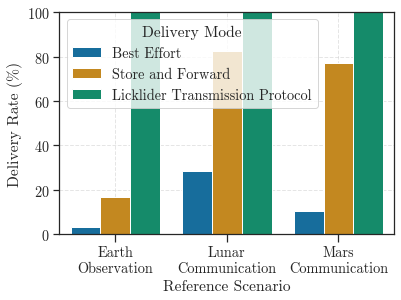

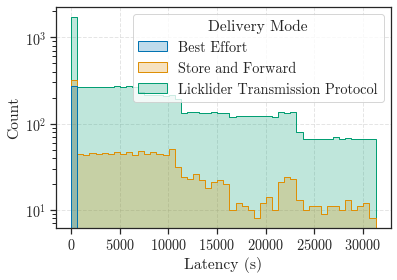

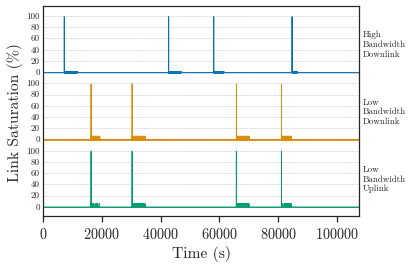

In [124]:
plot_delivery_rates(df_messages, df_bw, size=0.5, output_pdf="delivery-rates.pdf")

df_messages['latency'] = df_messages['end_time'] - df_messages['start_time']
df_filtered = df_messages[df_messages['latency'] < 60000]
plot_latencies_histogram(df_filtered, "Earth Observation", size=0.5, output_pdf="latencies-earth-observation.pdf")

plot_link_utilization_ridgeline_buckets(df_bw, "Earth Observation", "Store and Forward", filter_links=["2->4", "4->3", "4->2"], bucket_size=1, size=0.5, output_pdf="link-utilization-earth-observation.pdf")

### Custom

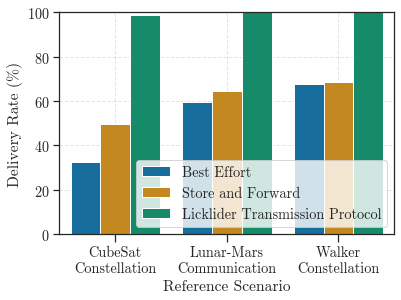

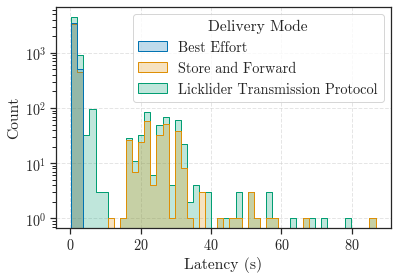

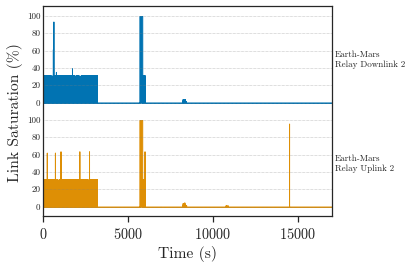

In [30]:
plot_delivery_rates(df_messages_custom, df_bw_custom, loc='lower right', size=0.5, output_pdf="delivery-rates-custom.pdf")

df_messages_custom['latency'] = df_messages_custom['end_time'] - df_messages_custom['start_time']
df_filtered = df_messages_custom[df_messages_custom['latency'] < 200]
plot_latencies_histogram(df_filtered, "Walker Constellation", size=0.5, output_pdf="latencies-walker.pdf")

plot_link_utilization_ridgeline_buckets(
    df_bw_custom,
    "Lunar-Mars Communication",
    "Licklider Transmission Protocol",
    custom=True,
    filter_links=None,
    bucket_size=1,
    size=0.5,
    output_pdf="link-utilization-lunar-mars.pdf",
)

### Table

In [39]:
df = pd.concat([df_messages, df_messages_custom], ignore_index=True)
df["latency"] = df["end_time"] - df["start_time"]

df_bw_temp = pd.concat([df_bw, df_bw_custom], ignore_index=True)

# filter walker
df = df[~((df["Scenario"] == "Walker") & (df["latency"] >= 2000))]

df["drop_reason"] = df["drop_reason"].replace({DropReason.DUPLICATE: np.nan})
df["is_dropped"] = df["dropped"] & df["drop_reason"].notna()

percent_summary = (
    df.groupby(["Scenario", "Delivery Mode"])
    .agg(
        Loss=("loss", "first"),
        Delivered_Percent=("delivered", lambda x: 100 * x.mean()),
        Dropped_Percent=("is_dropped", lambda x: 100 * x.mean()),
    )
    .reset_index()
)

delivered_df = df[df["delivered"] == True]
metrics_summary = (
    delivered_df.groupby(["Scenario", "Delivery Mode"])
    .agg(
        Latency_Mean=("latency", "mean"),
        Latency_Std=("latency", "std"),
        Hops_Mean=("hops", "mean"),
        Hops_Std=("hops", "std"),
    )
    .reset_index()
)

bw_summary = (
    df_bw_temp
    .groupby(["Scenario", "Delivery Mode"])
    .agg(
        Bandwidth_Mean=("bandwidth_use_ratio", lambda x: 100 * x.mean()),
        Bandwidth_Max=("bandwidth_use_ratio", lambda x: 100 * x.max()),
        # Bandwidth_Saturated=("bandwidth_use_ratio", lambda x: 100 * (x > 0.9).mean()),
    )
    .reset_index()
)

summary = percent_summary.merge(metrics_summary, on=["Scenario", "Delivery Mode"])
summary = summary.merge(bw_summary, on=["Scenario", "Delivery Mode"])
summary = summary.round(2)

summary = summary.rename(columns={
    "Delivered_Percent": "Delivered (%)",
    "Dropped_Percent": "Dropped (%)",
    "Latency_Mean": "Latency Mean (s)",
    "Latency_Std": "Latency Std (s)",
    "Hops_Mean": "Hops Mean",
    "Hops_Std": "Hops Std",
    "Bandwidth_Mean": "Mean Used Link Util. (%)",
    "Bandwidth_Max": "Max Link Util. (%)",
    # "Bandwidth_Saturated": "Saturated Links (%)",
})

scenario_order = {
    "Earth Observation": 0,
    "Lunar Communication": 1,
    "Mars Communication": 2,
    "Walker Constellation": 3,
    "CubeSat Constellation": 4,
    "Lunar-Mars Communication": 5,
}
delivery_order = {
    "Best Effort": 0,
    "Store and Forward": 1,
    "Licklider Transmission Protocol": 2,
}
summary["Scenario"] = pd.Categorical(
    summary["Scenario"],
    categories=sorted(scenario_order, key=lambda x: scenario_order[x]),
    ordered=True
)
summary["Delivery Mode"] = pd.Categorical(
    summary["Delivery Mode"],
    categories=sorted(delivery_order, key=lambda x: delivery_order[x]),
    ordered=True
)
summary = summary.sort_values(by=["Scenario", "Delivery Mode"])

# Drop columns
summary = summary.drop(columns=[
    "Latency Std (s)",
    "Hops Std",
])

summary['Loss'] = summary['Loss'] * 100
summary['Loss'] = summary['Loss'].replace(0.0, 0.5)
summary = summary.rename(columns={"Loss": "Loss (%)"})

summary.columns = summary.columns.str.replace('%', r'\%', regex=True)

latex_table = summary.to_latex(index=False, escape=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{llrrrrrrr}
\toprule
Scenario & Delivery Mode & Loss (\%) & Delivered (\%) & Dropped (\%) & Latency Mean (s) & Hops Mean & Mean Used Link Util. (\%) & Max Link Util. (\%) \\
\midrule
Earth Observation & Best Effort & 5.00 & 2.93 & 83.35 & 0.10 & 2.00 & 1.48 & 6.40 \\
Earth Observation & Store and Forward & 5.00 & 16.76 & 0.00 & 8986.45 & 2.00 & 7.79 & 100.00 \\
Earth Observation & Licklider Transmission Protocol & 5.00 & 100.00 & 0.00 & 9704.86 & 2.00 & 9.29 & 100.00 \\
Lunar Communication & Best Effort & 5.00 & 28.51 & 60.03 & 1.31 & 3.35 & 0.99 & 17.07 \\
Lunar Communication & Store and Forward & 5.00 & 82.62 & 0.00 & 4707.89 & 3.70 & 3.22 & 100.00 \\
Lunar Communication & Licklider Transmission Protocol & 5.00 & 100.00 & 0.00 & 4733.25 & 3.71 & 1.83 & 100.00 \\
Mars Communication & Best Effort & 5.00 & 10.34 & 86.89 & 1259.66 & 4.65 & 1.42 & 51.20 \\
Mars Communication & Store and Forward & 5.00 & 77.16 & 0.00 & 14732.93 & 5.05 & 13.06 & 100.00 \\
Mars Communication &